In [17]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import logging
from razor.api import project_space_path
from math import ceil
from razor.api import project_space_path
import razor
import razor.flow as rf
import typing as t
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [18]:
config = {'cpu': 8 , 'ram': 36000}

In [19]:
lib1 = razor.api.libraries(name='lightgbm').artifact()

In [20]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=3000))
class Configs:
    config: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        
        dic = {
          "TARGET": "sales",
          "END_TRAIN": 1913,
          "MAIN_INDEX": [
            "id",
            "d"
          ],
          'index_columns' : ['id','item_id','dept_id','cat_id','store_id','state_id'],
          "train_path": "M5Forecasting/sales_train_validation.csv",
          "prices_path": "M5Forecasting/sell_prices.csv",
          "calendar_path" : "M5Forecasting/calendar.csv"
        }
        self.config.put(dic)
        

In [21]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=10192))
class Melter:
    path: t.Any
    config: t.Any
    grid_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        
        train_df=pd.read_csv(project_space_path(self.path))
        print('Create Grid')
        TARGET = self.config["TARGET"]

        # We can tranform horizontal representation 
        # to vertical "view"
        # Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
        # and labels are 'd_' coulmns

        index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
        df = pd.melt(train_df, 
                          id_vars = index_columns, 
                          var_name = 'd', 
                          value_name = TARGET)
        
        del train_df
        gc.collect()
        
        df.to_csv(project_space_path('M5Forecasting/grid_df.csv'), index=False)
        self.grid_df_path.put('M5Forecasting/grid_df.csv')


In [22]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=8192))
class ValidDataCreator:
    path: t.Any
    config: t.Any
    add_grid_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
            
    def run(self):
        import pandas as pd
        import logging
        
        self.logger.info("Reading df")
        train_df=pd.read_csv(project_space_path(self.path))
        self.logger.info("Reading df DONE...")
        
        END_TRAIN = self.config["END_TRAIN"]
        TARGET = self.config["TARGET"]
        # If we look on train_df we se that 
        # we don't have a lot of traning rows
        # but each day can provide more train data
        print('Train rows:', len(train_df))

        # To be able to make predictions
        # we need to add "test set" to our grid
        index_columns = self.config['index_columns']
        df = pd.DataFrame()
        for i in range(1,29):
            temp_df = train_df[index_columns]
            temp_df = temp_df.drop_duplicates()
            temp_df['d'] = 'd_'+ str(END_TRAIN+i)
            temp_df[TARGET] = np.nan
            df = pd.concat([df,temp_df])
            
        del train_df
        gc.collect()
        df.to_csv(project_space_path('M5Forecasting/add_grid.csv'), index=False)
        self.add_grid_path.put('M5Forecasting/add_grid.csv')


In [23]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=13000))
class DataConcatenation:
    grid_df_path: t.Any
    add_grid_path: t.Any    
    config: t.Any    
    grid_df_int_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def sizeof_fmt(num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Yi', suffix)
        
        
    def run(self): 
        
        
        grid_df = pd.read_csv(project_space_path(self.grid_df_path))
        add_grid = pd.read_csv(project_space_path(self.add_grid_path))

        grid_df = pd.concat([grid_df,add_grid])
        grid_df = grid_df.reset_index(drop=True)


        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df', self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        # We can free some memory 
        # by converting "strings" to categorical
        # it will not affect merging and 
        # we will not lose any valuable data
        index_columns = self.config['index_columns']
        for col in index_columns:
            grid_df[col] = grid_df[col].astype('category')

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df', self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_int.csv'))
        self.grid_df_int_path.put('M5Forecasting/grid_df_int.csv')


In [24]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class DataCreator1:
    grid_df_path: t.Any
    config: t.Any
    grid_pkl_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    
    
    def sizeof_fmt(self, num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Yi', suffix)


    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1
    
    def run(self):
        from razor.api import project_space_path
        
        prices_df = pd.read_csv(project_space_path(self.config['prices_path']))
        grid_df = pd.read_csv(project_space_path(self.grid_df_path))
        self.logger.info(grid_df.dtypes)
        calendar_df = pd.read_csv(project_space_path(self.config['calendar_path']))
        # Prices are set by week
        # so it we will have not very accurate release week 
        release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
        release_df.columns = ['store_id','item_id','release']
        self.logger.info('Release Df')
        self.logger.info(release_df.head())
        
        self.logger.info('Release week')
        # Now we can merge release_df
        grid_df = self.merge_by_concat(grid_df, release_df, ['store_id','item_id'])
        del release_df


        grid_df = self.merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
        self.logger.info(grid_df.columns)

        self.logger.info(grid_df.dtypes)
        
        # Now we can cutoff some rows 
        # and safe memory 
        grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
        grid_df = grid_df.reset_index(drop=True)

        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df',self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df['release'] = grid_df['release'] - grid_df['release'].min()
        grid_df['release'] = grid_df['release'].astype(np.int16)

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df',self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        index_columns = self.config['index_columns']
        for col in index_columns:
            grid_df[col] = grid_df[col].astype('category')

        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
        self.logger.info(grid_df.shape)
        self.logger.info(grid_df.dtypes)
        
        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_final.csv'))
        self.grid_pkl_path.put(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
                       
                       

In [25]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class DataCreator2:
    grid_path: t.Any
    config: t.Any
    grid_two_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
           
    def sizeof_fmt(self, num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)

        
    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1

    def reduce_mem_usage(self, df, verbose=True):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2    
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                           df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
        end_mem = df.memory_usage().sum() / 1024**2

        if verbose: 
            print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

        return df
    
    def run(self):
        from razor.api import project_space_path

        prices_df=pd.read_csv(project_space_path(self.config["prices_path"]))
        calendar_df=pd.read_csv(project_space_path(self.config["calendar_path"]))
        
        self.logger.info('Release week')
        
        self.logger.info('Prices')

        # We can do some basic aggregations
        prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
        prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
        prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
        prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

        # and do price normalization (min/max scaling)
        prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

        # Some items are can be inflation dependent
        # and some items are very "stable"
        prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
        prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

        # I would like some "rolling" aggregations
        # but would like months and years as "window"
        calendar_prices = calendar_df[['wm_yr_wk','month','year']]
        calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
        prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
        del calendar_prices

        # Now we can add price "momentum" (some sort of)
        # Shifted by week 
        # by month mean
        # by year mean
        prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
        prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
        prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

        del prices_df['month'], prices_df['year']
        gc.collect()
        
        ########################## Merge prices and save part 2
        #################################################################################
        self.logger.info('Merge prices and save part 2')

        grid_df = pd.read_pickle(self.grid_path)
        MAIN_INDEX=self.config["MAIN_INDEX"]
        
        # Merge Prices
        original_columns = list(grid_df)
        grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
        keep_columns = [col for col in list(grid_df) if col not in original_columns]
        grid_df = grid_df[MAIN_INDEX+keep_columns]
        grid_df = self.reduce_mem_usage(grid_df)

        # Safe part 2
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
        self.logger.info(f'Size: {grid_df.shape}')
        grid_two_df_filepath = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.grid_two_df_path.put(grid_two_df_filepath)

        

In [26]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class DataCreator3:
    grid_path: t.Any
    config: t.Any
    grid_three_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    
    def sizeof_fmt(self, num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Yi', suffix)


    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1
    
    def run(self):
        from razor.api import project_space_path
        
        calendar_df=pd.read_csv(project_space_path(self.config["calendar_path"]))
        grid_df = pd.read_pickle(self.grid_path)
        MAIN_INDEX=self.config["MAIN_INDEX"]
        
        ########################### Merge calendar
        #################################################################################
        grid_df = grid_df[MAIN_INDEX]

        # Merge calendar partly
        icols = ['date',
                 'd',
                 'event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']
        
        grid_df['d'] = grid_df['d'].apply(str)
        grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

        # Minify data
        # 'snap_' columns we can convert to bool or int8
        icols = ['event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']
        for col in icols:
            grid_df[col] = grid_df[col].astype('category')

        # Convert to DateTime
        grid_df['date'] = pd.to_datetime(grid_df['date'])

        # Make some features from date
        grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
        grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
        grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
        grid_df['tm_y'] = grid_df['date'].dt.year
        grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
        grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

        grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
        grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

        # Remove date
        del grid_df['date']
        ########################### Save part 3 (Dates)
        #################################################################################
        print('Save part 3')

        # Safe part 3
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))
        print('Size:', grid_df.shape)

        # We don't need calendar_df anymore
        del calendar_df
        del grid_df
        grid_three_df_filepath = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.grid_three_df_path.put(grid_three_df_filepath)



In [27]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class LagCreator:
    grid_path: t.Any
    lag_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        ########################### Apply on grid_df

        grid_df = pd.read_pickle(self.grid_path)

        TARGET = 'sales'         # Our main target
        END_TRAIN = 1913         # Last day in train set
        MAIN_INDEX = ['id','d']  # We can identify item by these columns
        
        # We need only 'id','d','sales'
        # to make lags and rollings
        grid_df = grid_df[['id','d','sales']]
        SHIFT_DAY = 28

        # Lags
        # with 28 day shift
        start_time = time.time()
        self.logger.info('Create lags')

        LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
        grid_df = grid_df.assign(**{
                '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
                for l in LAG_DAYS
                for col in [TARGET]
            })

        # Minify lag columns
        for col in list(grid_df):
            if 'lag' in col:
                grid_df[col] = grid_df[col].astype(np.float16)

        self.logger.info('%0.2f min: Lags' % ((time.time() - start_time) / 60))

        # Rollings
        # with 28 day shift
        start_time = time.time()
        self.logger.info('Create rolling aggs')

        for i in [7,14,30,60,180]:
            self.logger.info(f'Rolling period: {i}')
            grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
            grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

        # Rollings
        # with sliding shift
        for d_shift in [1,7,14]: 
            self.logger.info(f'Shifting period: {d_shift}')
            for d_window in [7,14,30,60]:
                col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
                grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)


        self.logger.info('%0.2f min: Lags' % ((time.time() - start_time) / 60))

        self.logger.info(f'Save lags and rollings  {grid_df.shape}')
        lag_df_filepath = project_space_path(f'M5Forecasting/lags_df_{str(SHIFT_DAY)}.pkl')
        grid_df.to_pickle(lag_df_filepath)
        
        self.lag_df_path.put(lag_df_filepath)
        


In [28]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=16192))
class Encoder:
    grid_path: t.Any
    encoded_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):

        # Read data
        grid_df = pd.read_pickle(self.grid_path)
        TARGET = 'sales'
        
        grid_df[["d"]] = grid_df[["d"]].apply(pd.to_numeric, errors='coerce', downcast="integer")
#         logging.info(grid_df.dtypes)
        grid_df[grid_df['d']>(1913-28)][TARGET] = np.nan
        base_cols = list(grid_df)

        icols =  [
                    ['state_id'],
                    ['store_id'],
                    ['cat_id'],
                    ['dept_id'],
                    ['state_id', 'cat_id'],
                    ['state_id', 'dept_id'],
                    ['store_id', 'cat_id'],
                    ['store_id', 'dept_id'],
                    ['item_id'],
                    ['item_id', 'state_id'],
                    ['item_id', 'store_id']
                    ]

        for col in icols:
            self.logger.info('Encoding')
            self.logger.info(col)
            col_name = '_'+'_'.join(col)+'_'
            grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
            grid_df['enc'+col_name+'std'] = grid_df.groupby(col)[TARGET].transform('std').astype(np.float16)

        keep_cols = [col for col in list(grid_df) if col not in base_cols]
        grid_df = grid_df[['id','d']+keep_cols]

        self.logger.info('Save Mean/Std encoding')
        encoded_df_filepath = project_space_path('/M5Forecasting/mean_encoding_df.pkl')
        grid_df.to_pickle(encoded_df_filepath)
        self.encoded_df_path.put(encoded_df_filepath)
        


In [29]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=36000, gpu=1))
class Train:
    BASE: t.Any
    PRICE: t.Any
    CALENDAR: t.Any
    LAGS: t.Any     
    MEAN_ENC: t.Any   
        
    __libs__ = [lib1]
    
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
#         self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl')
#         self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
#         self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
#         self.LAGS     = project_space_path('M5Forecasting/lags_df_28.pkl')
#         self.MEAN_ENC = project_space_path('M5Forecasting/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = '../input/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]
        
        self.remove_features = ['id','state_id','store_id',
                           'date','wm_yr_wk','d', self.TARGET]
        self.mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                           'enc_dept_id_mean','enc_dept_id_std',
                           'enc_item_id_mean','enc_item_id_std'] 

            
    def seed_everything(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)


    ## Multiprocess Runs
    def df_parallelize_run(self, func, t_split):
        num_cores = np.min([self.N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df

    def get_data_by_store(self, store):

        # Read and contact basic feature
        df1 = pd.read_pickle(self.BASE)
#         df1 = df1[df1['store_id']==store]
        df2 = pd.read_pickle(self.PRICE).iloc[:,2:]
#         df2 = df2[df2['store_id']==store]
        df3 = pd.read_pickle(self.CALENDAR).iloc[:,2:]
        df = pd.concat([df1, df2, df3],
                        axis=1)

        # Leave only relevant store
        df = df[df['store_id']==store]
        df = df.drop(['Unnamed: 0'], 1)

        df2 = pd.read_pickle(self.MEAN_ENC)[self.mean_features]
        df2 = df2[df2.index.isin(df.index)]

        df = pd.concat([df, df2], axis=1)
        del df2 # to not reach memory limit 
        gc.collect()

        df3 = pd.read_pickle(self.LAGS).iloc[:,3:]
        df3 = df3[df3.index.isin(df.index)]


        df = pd.concat([df, df3], axis=1)
        del df3 # to not reach memory limit 
        gc.collect()

        # Create features list
        features = [col for col in list(df) if col not in self.remove_features]
        df = df[['id','d',self.TARGET]+features]

        # Skipping first n rows
        df['d'] = df['d'].apply(lambda x: x[2:]).astype(np.int16)
        df = df[df['d']>=self.START_TRAIN].reset_index(drop=True)

        return df, features

    # Recombine Test set after training
    def get_base_test(self):
        base_test = pd.DataFrame()

        for store_id in self.STORES_IDS:
            temp_df = pd.read_pickle('test_'+store_id+'.pkl')
            for col in ['item_id', 'dept_id', 'cat_id']:
                temp_df[col] = temp_df[col].astype('category')
            temp_df['store_id'] = store_id
            base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

        return base_test


    ########################### Helper to make dynamic rolling lags
    #################################################################################
    def make_lag(self, LAG_DAY):
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'sales_lag_{str(LAG_DAY)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
        return lag_df[[col_name]]


    def make_lag_roll(self, LAG_DAY):
        shift_day = LAG_DAY[0]
        roll_wind = LAG_DAY[1]
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
        return lag_df[[col_name]]
    
    def run(self):
                         
        import logging


        import lightgbm as lgb
        lgb_params = {
                            'boosting_type': 'gbdt',
                            'objective': 'tweedie',
                            'tweedie_variance_power': 1.1,
                            'metric': 'rmse',
                            'subsample': 0.5,
                            'subsample_freq': 1,
                            'learning_rate': 0.03,
                            'num_leaves': 2**11-1,
                            'min_data_in_leaf': 2**12-1,
                            'feature_fraction': 0.5,
                            'max_bin': 100,
                            'n_estimators': 1400,
                            'boost_from_average': False,
                            'verbose': -1,
                        } 


                ########################### Vars
        #################################################################################
        VER = 1                          # Our model version
        SEED = 42                      
        self.seed_everything(SEED)      
        lgb_params['seed'] = SEED        

        #FEATURES to remove
        ## These features lead to overfit
        ## or values not present in test set

        ROLS_SPLIT = []
        
        for i in [1,7,14]:
            for j in [7,14,30,60]:
                ROLS_SPLIT.append([i,j])


        if self.USE_AUX:
            lgb_params['n_estimators'] = 2

        

                ########################### Train Models
        #################################################################################
        for store_id in self.STORES_IDS:
            self.logger.info('Train')
            self.logger.info(store_id)

            # Get grid for current store
            grid_df, features_columns = self.get_data_by_store(store_id)
#             self.logger.info(grid_df.head())            
            
            self.logger.info("Loaded grid Data")

            # Masks for 
            # Train (All data less than 1913)
            # "Validation" (Last 28 days - not real validatio set)
            # Test (All data greater than 1913 day, 
            #       with some gap for recursive features)
            train_mask = grid_df['d']<=self.END_TRAIN
            valid_mask = train_mask&(grid_df['d']>(self.END_TRAIN-self.P_HORIZON))
            preds_mask = grid_df['d']>(self.END_TRAIN-100)

            train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                               label=grid_df[train_mask][self.TARGET])
            
#             train_data.save_binary(project_space_path("M5Forecasting/train_data.bin"))
#             train_data = lgb.Dataset(project_space_path("M5Forecasting/train_data.bin"))

            valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                               label=grid_df[valid_mask][self.TARGET])

            # Saving part of the dataset for later predictions
            # Removing features that we need to calculate recursively 
            grid_df = grid_df[preds_mask].reset_index(drop=True)
            keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
            grid_df = grid_df[keep_cols]
            grid_df.to_pickle(project_space_path(f"M5Forecasting/test_{store_id}.pkl"))
            del grid_df
            gc.collect()

            # Launch seeder again to make lgb training 100% deterministic
            # with each "code line" np.random "evolves" 
            # so we need (may want) to "reset" it
            self.seed_everything(SEED)
            estimator = lgb.train(lgb_params,
                                  train_data,
                                  valid_sets = [valid_data],
                                  verbose_eval = 100,
                                  )


            model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
            pickle.dump(estimator, open(project_space_path(f"M5Forecasting/{model_name}"), 'wb'))

            # Remove temporary files and objects 
            # to free some hdd space and ram memory

#             os.remove()
            del train_data, valid_data, estimator
            gc.collect()

            # "Keep" models features for predictions
            MODEL_FEATURES = features_columns



In [30]:
configs = Configs()
melter = Melter(path='M5Forecasting/train_df.csv',config=configs.config)
valid_creator = ValidDataCreator(path='M5Forecasting/train_df.csv', config=configs.config)
data_concat = DataConcatenation(config=configs.config, add_grid_path=valid_creator.add_grid_path, grid_df_path=melter.grid_df_path)
data_creator1 = DataCreator1(config=configs.config, grid_df_path=data_concat.grid_df_int_path)
data_creator2 = DataCreator2(config=configs.config, grid_path=data_creator1.grid_pkl_path)
data_creator3 = DataCreator3(config=configs.config, grid_path=data_creator1.grid_pkl_path)
lag_creator = LagCreator(grid_path = data_creator1.grid_pkl_path)
encoder = Encoder(grid_path=data_creator1.grid_pkl_path)

train = Train(BASE=data_creator1.grid_pkl_path, PRICE=data_creator2.grid_two_df_path, CALENDAR=data_creator3.grid_three_df_path, 
             LAGS=lag_creator.lag_df_path, MEAN_ENC=encoder.encoded_df_path)


In [31]:
# train = Train()


In [32]:
p = rf.Pipeline("Walmart Training Pipeline_gpu", targets=[train])  #preprocess


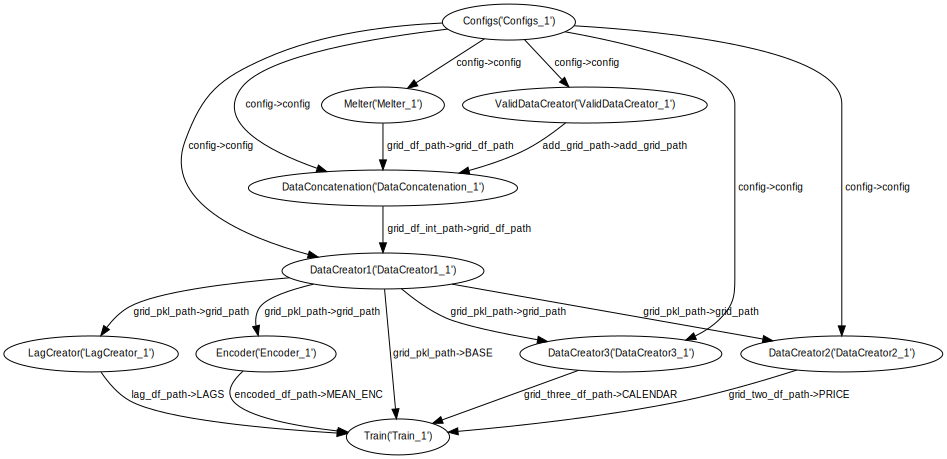

In [33]:
p

In [34]:
deployed_pipeline = razor.api.engines('DS-Engine-Load-Test').execute(pipeline=p)


In [35]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='141100e0-3acd-11eb-afb1-0242ac110005', pipeline_name='Walmart Training Pipeline_gpu', pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_version=None, comment=None, created_on='2020-12-10T09:50:05.234+00:00', start_time=None, end_time=None, eta=0, run_at=1607593805234, run_duration=0, compute_time=0, wait_time=2486, ran_by_user=RanByUser(user_name='Pratiksha Parsai', email='pratiksha.parsai@razorthink.com'), status='YET_TO_START', block_status=[PlatformPipelineBlockRun(pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_name='Walmart Training Pipeline_gpu', pipeline_status='YET_TO_START', block_id='89d41f37-7481-4601-bdd5-50baa9243e73', block_run_id='a1473ae5-a5f8-4515-998e-3db123cd11f2', block_name='Configs_1', resource_spec=ResourceAllocated(cores=2, memory=3000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='89d41f37-7481-4601-bdd5-50baa9243e73', _log=None, _metric=None, wait_time=2, compute_time=0, start_time=None, end_time=None, queued_at='2020-12-10T09:50:09.000+00:00'), PlatformPipelineBlockRun(pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_name='Walmart Training Pipeline_gpu', pipeline_status='YET_TO_START', block_id='41eb4ce2-0607-43fb-90f3-ded74ad529c8', block_run_id='f4f4248f-18b7-45ac-aa60-004b80b75d5e', block_name='ValidDataCreator_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='41eb4ce2-0607-43fb-90f3-ded74ad529c8', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_name='Walmart Training Pipeline_gpu', pipeline_status='YET_TO_START', block_id='8ce4fc16-2db8-490d-bc31-5569bd88744c', block_run_id='a725349f-7c1f-41f3-8663-f68305c8ca8c', block_name='Melter_1', resource_spec=ResourceAllocated(cores=2, memory=10192, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='8ce4fc16-2db8-490d-bc31-5569bd88744c', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_name='Walmart Training Pipeline_gpu', pipeline_status='YET_TO_START', block_id='c1a31644-4fe1-459f-867e-b47320bea035', block_run_id='37ae87f3-1ca6-4093-8a03-3c751a1c164d', block_name='DataConcatenation_1', resource_spec=ResourceAllocated(cores=2, memory=13000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='c1a31644-4fe1-459f-867e-b47320bea035', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='219f20dd-a087-4edc-828e-bf40c5db4504', pipeline_name='Walmart Training Pipeline_gpu', pipeline_status='YET_TO_START', block_id='c92cc8f9-48ea-4af2-9c0c-e0512e7d1cda', block_run_id='3e344b8f-57c9-4b10-a692-d42c2db72db2', block_name='DataCreator1_1', resource_spec=Resour